# Assignment 1

In [3]:

import math, random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# Load in the training set
X_train = np.load('data_a1/train_data.npy')
y_train = np.load('data_a1/train_label.npy')
# Reshape the label to a 1-d vector
y_train = y_train.reshape(-1,)

# # Load in the test set
X_test = np.load('data_a1/test_data.npy')
y_test = np.load('data_a1/test_label.npy')
# Reshape the label to a 1-d vector
y_test = y_test.reshape(-1,)

# Normalize (optional)
def normalize(X, X2):
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    X2 = (X2 - X.mean(axis=0)) / X.std(axis=0) # Normalize the data with the mean and sd from train set
    return X, X2

X_train, X_test = normalize(X_train, X_test)

print("Loaded dataset and normalized")

Loaded dataset and normalized


## Data Exploration

In [5]:
df = pd.DataFrame(X_train)

print('There are {} rows and {} features.'.format(X_train.shape[0], X_train.shape[1]))
print()
# Check if there is missing value
df_na = df.isna().sum()
print("There is {} missing value.".format(len(df_na[df_na > 0])))
print()

df_ranged = df.max(axis=0) - df.min(axis=0)
print("The largest and smallest range of a feature is {:.2f} and {:.2f}.".format(df_ranged.max(), df_ranged.min()))
print()

# Function to return the upper and lower boundary
# for not being a outlier
def iqr(feature):
    q75, q25 = np.percentile(feature, [75 ,25])
    qr = q75 - q25
    upper = q75 + (1.5 * qr)
    lower = q25 - (1.5 * qr)
    return upper, lower

# Function to detect outlier
def outlier(i, upper, lower):
    if i > upper: return True
    elif i < lower: return True
    else: return False

# Dict to see how many outlier are there (%) in each feature
outlier_count = {}
for i in df.columns:
    up, low = iqr(df[i])
    detection = df[i].apply(lambda x: outlier(x, up, low))
    outlier_count[i] = detection.sum() * 100 / detection.count()


print("Average proportion of outliers is {:.2f}%.".format(np.array(list(outlier_count.values())).mean()))
print("Max proportion of outliers is {:.2f}%.".format(np.array(list(outlier_count.values())).max()))
print("Since the dataset has {} data points, we agree that the outliers won't impose great effect".format(df.shape[0]))

There are 50000 rows and 128 features.

There is 0 missing value.

The largest and smallest range of a feature is 21.29 and 6.59.

Average proportion of outliers is 2.59%.
Max proportion of outliers is 5.42%.
Since the dataset has 50000 data points, we agree that the outliers won't impose great effect


## Coding the Neural Network

In [6]:
# Creating a Dense Layer class
class dense:
    # Initiate the class with required input and output dimension, and regularization
    def __init__(self, input_dim, output_dim, w_regularizer_l1=0, w_regularizer_l2=0, 
b_regularizer_l1=0, b_regularizer_l2=0):
        
        # Initiate the weights and bias
        self.w = 0.01 * np.random.randn(input_dim, output_dim)
        self.b = np.zeros((1, output_dim))
        
        # Initiate the regularizer lambda value
        self.w_regularizer_l1 = w_regularizer_l1
        self.w_regularizer_l2 = w_regularizer_l2
        self.b_regularizer_l1 = b_regularizer_l1
        self.b_regularizer_l2 = b_regularizer_l2
    
    # Forward propagation of the Dense layer
    def forward(self, inputs):
        self.inputs = inputs # Save the inputs when it is pased into the layer
        self.output = inputs.dot(self.w) + self.b # Calculate the output of this later
    
    # Backward propagation of the Dense layer
    def backward(self, dvalues):
        # Get gradient on weights and bias
        # Dot product of input transposed and the gradient from previous layer
        self.d_w = np.dot(self.inputs.T, dvalues)
        self.d_b = np.sum(dvalues, axis=0, keepdims=True) # Sum up the delta from previous layer
        
        # Add the regularization penalties calculated from the original weights if to the gradient of the weights
        if self.w_regularizer_l1 > 0:
            dL1 = np.ones_like(self.w)
            # For negative weights, the derivative of it is -1
            dL1[self.w < 0] = -1
            self.d_w += self.w_regularizer_l1 * dL1
        
        if self.w_regularizer_l2 > 0:
            self.d_w += 2 * self.w_regularizer_l1 * self.w

        # Add the regularization penalties calculated from the original bias if to the gradient of the weights
        if self.b_regularizer_l1 > 0:
            dL1 = np.ones_like(self.b)
            # For negative bias, the derivative of it is -1
            dL1[self.b < 0] = -1
            self.d_w += self.b_regularizer_l1 * dL1
        
        if self.b_regularizer_l2 > 0:
            self.d_b += self.b_regularizer_l2 * self.b
            
        # Gradient wrt inputs to be backprogated to the next layer
        self.dinputs = np.dot(dvalues, self.w.T)
    
# Create the ReLu activaton layer class
class ReLu:
    
    # Forward propagation for ReLu
    def forward(self, inputs):
        self.inputs = inputs # Save the inputs passed into this later
        self.output = np.maximum(0, inputs) # Apply the relu function on each inputs
    
    # Back propagation for Relu
    def backward(self, dvalues):
        # Use the copy of the gradient instead on changing them
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <0] = 0 # Apply the derivative of ReLu to the gradient wrt to gradient from last layer

# Create the Softmax layer class
class softmax:
    # Forward propagation for Softmax
    def forward(self, inputs):
        self.inputs = inputs # Save the inputs passed into this layer
        
        # Apply the softmax function to the input
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        prob = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        # Save the output values (predicted probabilities of each class) in this layer
        self.output = prob
    
    # Back propagation for Softmax
    def backward(self, dvalues):
        # Create an empty array with shape (n_class,)
        self.inputs = np.empty_like(dvalues)
        
        # Calculating the gradient of Softmax layer using its derivative
        for idx, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacob_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
        self.dinputs[idx] = np.dot(jacob_matrix, single_dvalue)
    
# Create a general Loss class for different loss function
class Loss:
    
    # Add l1, l2, loss to a lump sum regularization loss
    def regularization_loss(self, layer):
        regularization_loss = 0
        # Add l1 loss of weights to regularization loss
        if layer.w_regularizer_l1 > 0:
            regularization_loss += layer.w_regularizer_l1 * np.sum(np.abs(layer.w))
        # Add l2 loss of weights to regularization loss
        if layer.w_regularizer_l2 > 0:
            regularization_loss += layer.w_regularizer_l2 * np.sum(np.abs(layer.w * layer.w))
        # Add l1 loss of biasa to regularization loss 
        if layer.b_regularizer_l1 > 0:
            regularization_loss += layer.b_regularizer_l1 * np.sum(np.abs(layer.b))
        # Add l2 loss of biasa to regularization loss
        if layer.b_regularizer_l2 > 0:
            regularization_loss += layer.b_regularizer_l1 * np.sum(np.abs(layer.b * layer.b))
        
        return regularization_loss
    
    # A vanilla way to calculate loss using the loss function without regularization
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss
    
# Create Crossentropy loss class with inherit the generl Loss class
class Loss_CategoricalCrossentropy(Loss):
    
    # Forward propagation of CrossEntropy loss function
    # which takes the output of the softmax layer as y_pred
    def forward(self, y_pred, y):
        sample = len(y_pred)
        
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7) # clipped the prediction to avoid divisio by 0
        
        if len(y.shape) == 1:
            # Produce the vector of the predicted probability of the correct label
            correct_confidence = y_pred_clipped[range(sample), y] 
        if len(y.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y, axis=1)
        
        # Calculate the negative log likelihoods
        negative_log_likelihoods = -np.log(correct_confidence)
        return negative_log_likelihoods
    
    # Back propagation of CrossEntropy loss function
    def backward(self, dvalues, y):
        
        # Get the number of predictions (length of y_pred)
        sample = len(dvalues)
        # Get the number of class in the prediction
        labels = len(dvalues[0])
        
        # Create one-hot encoding if y is an index label
        if len(y.shape) == 1:
            y = np.eye(labels)[y]
        
        # Calculate the gradient wrt to input values using the derivative of the crossentropy loss
        self.dinputs = -y / dvalues
        
        # Normalize the gradient according to the batch size
        self.dinputs = self.dinputs / sample

# Create the output layer as a combination of Softmax and CrossEntroly Loss
class softmax_crossentropy_loss():
    
    # Initiate the layer with the chosen activation and loss function
    def __init__(self):
        self.activation = softmax()
        self.loss = Loss_CategoricalCrossentropy()
    
    # Forward propogation for this layer
    def forward(self, inputs, y, test=False):
            
            # Get predictsion by pass forwad in the Softmax class
            # with the input it received from the previous layer
            self.activation.forward(inputs)
            
            # Save the output values (prediction) in this layer
            self.output = self.activation.output
            
            # If we are doing testing, no more follow up action
            if test == True:
                pass
            # During training, use the chosen loss function to get the loss
            elif test == False:
                return self.loss.calculate(self.output, y)
    
    # Back propagation for this layer
    def backward(self, dvalues, y):
        sample = len(dvalues)
        
        # In case the predicted values are vector
        # Get the index with highest probability
        if len(y) == 2:
            y = np.argmax(y, axis=1)
        
        # Calculate the gradient of from the cross entropy loss
        # dinputs and dvalues here are the output (prediction) from the output layer (softmax)
        self.dinputs = dvalues.copy()
        self.dinputs[range(sample), y] -= 1 # Calculate the gradient of loss and softmax using chain rule
        self.dinputs = self.dinputs / sample # Normalize the gradient

# Create the Optimizer (Stochastic gradient descent) class
class Optimizer_SGD:
    
    # Initiate the class with the learning rate, decay rate and momentum
    def __init__(self, lr=0.1, decay=0., momentum=0.):
        self.lr = lr
        self.current_lr = lr
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Precall the decay function
    # Since interation initiated at 0, the learning rate is still the preset one
    def pre_update(self):
        # Continue update the learning rate with the decay rate after each epochs
        if self.decay:
            self.current_lr = self.lr * (1 / (1 + self.decay * self.iterations))
    
    # Update the weights and bias with the gradient from back propagation
    def update_params(self, layer):
        
        # If there is a momentum, we apply momentun to the updates
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                
                # Momentum at start is 0
                layer.weight_momentums = np.zeros_like(layer.w)
                layer.bias_momentum = np.zeros_like(layer.b)
            
            # The negative update is increased by the momentum
            w_updates = self.momentum * layer.weight_momentums - self.current_lr * layer.d_w
            
            # Update the momentum from the update after each epoch
            layer.weight_momentums = w_updates
            
            # Similar handling for bias
            b_updates = self.momentum * layer.bias_momentum - self.current_lr * layer.d_b
            layer.bias_momentum = b_updates
        
        else:
            # Regular updates by multiplying the gradient with the learning rate
            w_updates = -self.current_lr * layer.d_w
            b_updates = -self.current_lr * layer.d_b
        
        # Update the weights and bias
        layer.w += w_updates
        layer.b += b_updates
        
    def update_BN_param(self, layer):
        
        # If there is a momentum, we apply momentun to the updates
        if self.momentum:
            if not hasattr(layer, 'gamma_momentums'):
                
                # Momentum at start is 0
                layer.gamma_momentums = np.zeros_like(layer.gamma)
                layer.beta_momentum = np.zeros_like(layer.beta)
            
            # The negative update is increased by the momentum
            gamma_updates = self.momentum * layer.gamma_momentums - self.current_lr * layer.d_gamma
            
            # Update the momentum from the update after each epoch
            layer.gamma_momentums = gamma_updates
            
            # Similar handling for bias
            beta_updates = self.momentum * layer.beta_momentum - self.current_lr * layer.d_beta
            layer.beta_momentum = beta_updates
        
        else:
            # Regular updates by multiplying the gradient with the learning rate
            gamma_updates -= self.current_lr * layer.d_gamma
            beta_updates -= self.current_lr * layer.d_beta
        
        # Update the weights and bias
        layer.gamma += gamma_updates
        layer.beta += beta_updates
    
    # Keep track of the number of epoches
    def post_update(self):
        self.iterations += 1

# Create the Dropout layer
class Dropout:
    # Initiate layer with drop out rate (drop out here is the ratio of units to be disabled)
    def __init__(self, rate):
        self.rate = 1-rate
    
    # Forward propagation for dropout layer
    def forward(self, inputs):
        # Save the inputs in this layer
        self.inputs = inputs
        
        # Create the mask using the bernoulli distribution with rate as the probability
        # Dividing the self.rate keeps the total values of the input the same
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        
        # Disable the randomly selected neurons
        self.output = inputs * self.binary_mask
        
    # Back propagation for Drop out layer
    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

# Create the Batch Normalization layer
class Batch_norm:
    
    # Initiate the learnable parameters gamma and beta with default values
    def __init__(self,gamma=0.99, beta=0.):
        self.g = gamma
        self.b = beta
    
    # Forward propagation
    def forward(self, inputs):

        # Save the output from previous layer as inputs
        self.inputs = inputs

        # Get the mean, variance of this batch
        self.x_mean = inputs.mean(axis=0)
        self.x_var = inputs.var(axis=0)

        # Normalize the batch using the equation from the paper
        self.inv_var = 1/ (self.x_var + 1e-7)
        output = (inputs - self.x_mean) * (self.inv_var) ** 0.5

        # Save the output of this layer and to pass it to the next layer
        self.output = output
    
    # Backward propagation
    def backward(self, dvalues):
        
        # Get the number of samples and the dimension of the data
        N, d = dvalues.shape

        # Initiate the learnable parameters
        self.gamma = np.full((N, d), self.g)
        self.beta = np.full((N, d), self.b)
        
        # Assign the normalized values as x_til for simpler code
        x_til = self.output

        # intermediate partial derivatives
        dx_til = dvalues * self.gamma

        # final partial derivatives
        dinputs = (1. / N) * self.inv_var  * (N*dx_til - np.sum(dx_til, axis=0)
            - x_til*np.sum(dx_til*x_til, axis=0))
        dbeta = np.sum(dvalues, axis=0)
        dgamma = np.sum(x_til*dvalues, axis=0)
        
        # return the gradient and pass them to the next layer if suitable
        self.dinputs = dinputs
        self.d_gamma = dgamma
        self.d_beta = dbeta

In [14]:
# Apply Mini-batch
def create_batches(inputs, targets, batchsize=64):

    assert inputs.shape[0] == targets.shape[0] # Ensure the input and label has same length
    indices = np.arange(inputs.shape[0]) # Create a list of indices with length of the input samples
    np.random.shuffle(indices) # Random sample the indices

    # Yield the batches for training
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# A function to save all the training and testing result for easier retrieval later
def save_info_df(acc_train_df=None, loss_train_df=None, acc_test_series=None, loss_test_series=None, test_names=test_name, new=False):

    accuracy_train = {}
    loss_train = {}
    accuracy_test = {}
    loss_test = {}

    # Fill the dictionary
    for i, j in enumerate(test_name):
        accuracy_train[j] = all_acc[i]
        loss_train[j] = all_loss[i]
        accuracy_test[j] = test_acc[i]
        loss_test[j] = test_loss[i]

    # If there is no df loaded, we will create a new df
    if new:
        acc_train_df =  pd.DataFrame(accuracy_train)
        loss_train_df =  pd.DataFrame(loss_train)
        acc_test_series =  pd.Series(accuracy_test)
        loss_test_series =  pd.Series(loss_test)

    else:
        # Convert the date into pandas df
        add_acc_train_df =  pd.DataFrame(accuracy_train)
        add_loss_train_df =  pd.DataFrame(loss_train)
        add_acc_test_series =  pd.Series(accuracy_test)
        add_loss_test_series =  pd.Series(loss_test)

        acc_train_df = pd.concat([acc_train_df, add_acc_train_df], axis=1)
        loss_train_df = pd.concat([loss_train_df, add_loss_train_df], axis=1)

        acc_test_series = acc_test_series.append(add_acc_test_series)
        loss_test_series = loss_test_series.append(add_loss_test_series)

    return acc_train_df, loss_train_df, acc_test_series, loss_test_series

## 1-FC layer

In [17]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    activation1 = ReLu()

    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN, Relu, Dropout)
            dense1.forward(x_batch)
            
            data_loss = loss_activation.forward(dense1.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)

            dense1.backward(loss_activation.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and calculate the accuracy and loss

        # Block 1 with (Dense, Relu, Dropout)
        dense1.forward(X_train)
        

        val_loss = loss_activation.forward(dense1.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(accuracy)
        loss_train.append(val_loss)

    all_acc.append(acc_train)
    all_loss.append(loss_train)

    # Evaluate on the test set
    dense1.forward(X_test)


    loss = loss_activation.forward(dense1.output, y_test)
    prediction = np.argmax(loss_activation.output, axis=1)

    if len(y_test) == 2:
        y_test = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_test==prediction)

    print("Testing accuracy")
    print("-"*50)
    print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

    print("Done training")
    test_acc.append(accuracy)
    test_loss.append(loss)

    return all_acc, all_loss

Testing accuracy
--------------------------------------------------
acc:0.3185 |loss:3.4841
Done training
Testing accuracy
--------------------------------------------------
acc:0.3186 |loss:3.4802
Done training
Testing accuracy
--------------------------------------------------
acc:0.3176 |loss:3.4631
Done training


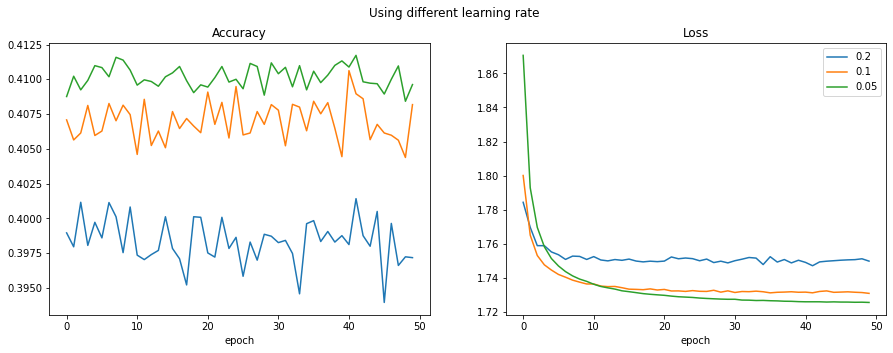

In [18]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.2, 0.1, 0.05]
dropout_rate = 0

all_acc = []
all_loss = []
test_acc = []
test_loss = []
for i in learning_rate:
    experiment(50, batch_size, i, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test)


fig, axs = plt.subplots(1,2, figsize=(15,5))

for label, i in enumerate(all_acc):
    axs[0].plot(i, label=learning_rate[label])

axs[0].set_title("Accuracy")
axs[0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[1].plot(i, label=learning_rate[label])
axs[1].set_title("Loss")
axs[1].set_xlabel("epoch")


fig.suptitle('Using different learning rate')
plt.legend()
plt.show()


test_name = ['1f_lr_02', '1f_lr_001', '1f_lr_005']

acc_train_df, loss_train_df, acc_test_series, loss_test_series = save_info_df(test_name, new=True)

## 2-FC layer

In [36]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    activation1 = ReLu()

    dense2 = dense(64,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, BN, Relu, Dropout)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)
            
            # Block 2 with (Dense)
            dense2.forward(activation1.output)
            data_loss = loss_activation.forward(dense2.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense2.backward(loss_activation.dinputs)

            activation1.backward(dense2.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and calculate the accuracy and loss

        # Block 1 with (Dense, Relu, Dropout)
        dense1.forward(X_train)
        activation1.forward(dense1.output)
        
        dense2.forward(activation1.output)

        val_loss = loss_activation.forward(dense2.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(accuracy)
        loss_train.append(val_loss)

    all_acc.append(acc_train)
    all_loss.append(loss_train)

    # Evaluate on the test set
    dense1.forward(X_test)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    loss = loss_activation.forward(dense2.output, y_test)
    prediction = np.argmax(loss_activation.output, axis=1)

    if len(y_test) == 2:
        y_test = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_test==prediction)

    print("Testing accuracy")
    print("-"*50)
    print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

    print("Done training")
    test_acc.append(accuracy)
    test_loss.append(loss)

    return all_acc, all_loss

Testing accuracy
--------------------------------------------------
acc:0.3742 |loss:3.7999
Done training
Testing accuracy
--------------------------------------------------
acc:0.3799 |loss:3.6200
Done training
Testing accuracy
--------------------------------------------------
acc:0.3701 |loss:3.8167
Done training


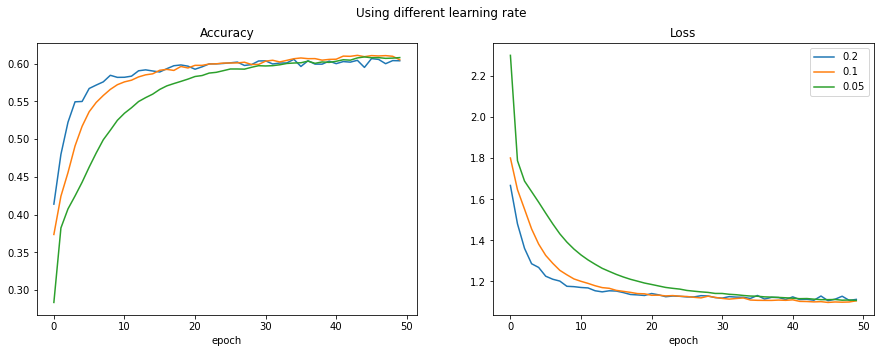

In [37]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.2, 0.1, 0.05]
dropout_rate = 0.0


all_acc = []
all_loss = []
test_acc = []
test_loss = []
for i in learning_rate:
    experiment(50, batch_size, i, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test)


fig, axs = plt.subplots(1,2, figsize=(15,5))

for label, i in enumerate(all_acc):
    axs[0].plot(i, label=learning_rate[label])

axs[0].set_title("Accuracy")
axs[0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[1].plot(i, label=learning_rate[label])
axs[1].set_title("Loss")
axs[1].set_xlabel("epoch")


fig.suptitle('Using different learning rate')
plt.legend()
plt.show()


test_name = ['2f_vanilla_lr_02', '2f_vanilla_lr_001', '2f_vanilla_lr_005']

acc_train_df, loss_train_df, acc_test_series, loss_test_series = save_info_df(test_name, new=True)

## 3-FC layer

In [44]:
def experiment(epochs, batch_size, learning_rate, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test):

    # Model architecture
    dense1 = dense(128,64, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    activation1 = ReLu()

    dense2 = dense(64,32, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    activation2 = ReLu()
    
    dense3 = dense(32,16, w_regularizer_l2 = 5e-4,b_regularizer_l2 = 5e-4)
    loss_activation = softmax_crossentropy_loss()

    optimizer = Optimizer_SGD(learning_rate, decay=0, momentum=False)

    # Create list to save the accuracies and losses during training
    acc_train = []
    loss_train = []

    for epoch in range(epochs):
        
        # Mini-batch SGD
        for batch in create_batches(X_train, y_train, batch_size):
            x_batch, y_batch = batch
            
            # Block 1 with (Dense, Relu)
            dense1.forward(x_batch)
            activation1.forward(dense1.output)
            
            # Block 2 with (Dense, Relu)
            dense2.forward(activation1.output)
            activation2.forward(dense2.output)
            
            #Block 3 with (Dense)
            dense3.forward(activation2.output)
            data_loss = loss_activation.forward(dense3.output, y_batch)

            # Add up the regularization loss
            regularization_loss = loss_activation.loss.regularization_loss(dense1) \
            + loss_activation.loss.regularization_loss(dense2) \
            + loss_activation.loss.regularization_loss(dense3)

            # Calculate the total loss of this epoch training for visualization later
            loss = data_loss + regularization_loss

            # Backpropagation
            loss_activation.backward(loss_activation.output, y_batch)
            dense3.backward(loss_activation.dinputs)
            
            activation2.backward(dense3.dinputs)
            dense2.backward(activation2.dinputs)

            activation1.backward(dense2.dinputs)
            dense1.backward(activation1.dinputs)

            # Update optimizer paramters
            optimizer.pre_update()

            # Update the weights and bias in the dense layers
            optimizer.update_params(dense1)
            optimizer.update_params(dense2)
            optimizer.update_params(dense3)

            # Iteration + 1 for SGD with momentum
            optimizer.post_update()

        # Make a forward pass using the training set and calculate the accuracy and loss

        # Block 1 with (Dense, Relu, Dropout)
        dense1.forward(X_train)
        activation1.forward(dense1.output)
        
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        
        dense3.forward(activation2.output)

        val_loss = loss_activation.forward(dense3.output, y_train)

        prediction = np.argmax(loss_activation.output, axis=1)
        if len(y_train) == 2:
            y_train = np.argmax(y_train, axis=1)
        accuracy = np.mean(y_train==prediction)
        
        # Save the accuracy and loss for visualization
        acc_train.append(accuracy)
        loss_train.append(val_loss)

    all_acc.append(acc_train)
    all_loss.append(loss_train)

    # Evaluate on the test set
    dense1.forward(X_test)
    activation1.forward(dense1.output)

    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
        
    dense3.forward(activation2.output)
    loss = loss_activation.forward(dense3.output, y_test)
    prediction = np.argmax(loss_activation.output, axis=1)

    if len(y_test) == 2:
        y_test = np.argmax(y_test, axis=1)
    accuracy = np.mean(y_test==prediction)

    print("Testing accuracy")
    print("-"*50)
    print(f"acc:{accuracy:.4f} |loss:{loss:.4f}")

    print("Done training")
    test_acc.append(accuracy)
    test_loss.append(loss)

    return all_acc, all_loss

Testing accuracy
--------------------------------------------------
acc:0.3837 |loss:3.4915
Done training
Testing accuracy
--------------------------------------------------
acc:0.3772 |loss:3.5602
Done training
Testing accuracy
--------------------------------------------------
acc:0.3826 |loss:3.4182
Done training


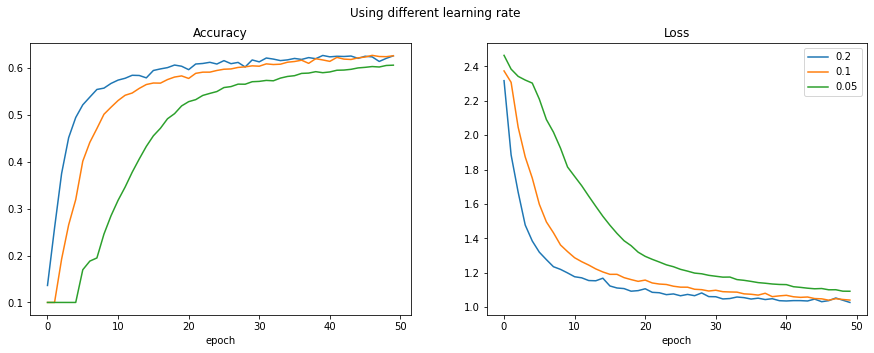

In [45]:
#Set some of the paramaters for the training process
epochs = 50
batch_size = 128
learning_rate = [0.2, 0.1, 0.05]
dropout_rate = 0.0


all_acc = []
all_loss = []
test_acc = []
test_loss = []
for i in learning_rate:
    experiment(50, batch_size, i, dropout_rate, all_acc, all_loss, test_acc, test_loss, y_train, y_test)


fig, axs = plt.subplots(1,2, figsize=(15,5))

for label, i in enumerate(all_acc):
    axs[0].plot(i, label=learning_rate[label])

axs[0].set_title("Accuracy")
axs[0].set_xlabel("epoch")

for label, i in enumerate(all_loss):
    axs[1].plot(i, label=learning_rate[label])
axs[1].set_title("Loss")
axs[1].set_xlabel("epoch")


fig.suptitle('Using different learning rate')
plt.legend()
plt.show()


test_name = ['3f_vanilla_lr_02', '3f_vanilla_lr_001', '3f_vanilla_lr_005']

acc_train_df, loss_train_df, acc_test_series, loss_test_series = save_info_df(test_name, new=True)